# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis. Classification case pos/neutral/neg only.

In [1]:
import os, re, string, pickle, random

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem

import emoji

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename them uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable and offensive texts
labeled_data = labeled_data[labeled_data.rating != -2]
labeled_data = labeled_data[labeled_data.rating != 30]

# Remap rating labels
new_rating_schema = {0: 1, 10: 0, 20:-1}
labeled_data.rating = labeled_data.rating.map(new_rating_schema)

labeled_data.shape

(1096, 3)

New rating schema: {1: "positive", 0: "neutral", -1: "negative"}

In [5]:
labeled_data.rating.value_counts()

-1    518
 0    391
 1    187
Name: rating, dtype: int64

Text cleansing

In [6]:
stopwords_list = stopwords.words("german")
stemmer = Cistem()

def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    > Stemming
    > Stopwords removal
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”" + "–" + "‘" + "’" + "“" + "…" + "‼"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)
    split_emoji = emoji.get_emoji_regexp().split(num_replaced) # splits emoji from words away
    tokenized = word_tokenize(" ".join(split_emoji)) 
    cleaned_tokens = [word for word in tokenized if word not in stopwords_list]
    stemmed = [stemmer.stem(word) for word in cleaned_tokens]
    cleaned_txt = " ".join(stemmed)

    return cleaned_txt

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [7]:
labeled_data.isna().sum()

source         0
text           0
rating         0
cleaned_txt    0
dtype: int64

Distribution of sources

In [8]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 66
Avg count of doc per source: 16.606060606060606
Top 5 sources:


DIE_KRONE                 111
JOY_PAMELA_RENDIWAGNER    111
FLORIAN_KLENK              89
DER_STANDARD               70
NEOS                       64
Name: source, dtype: int64

Distribution of ratings

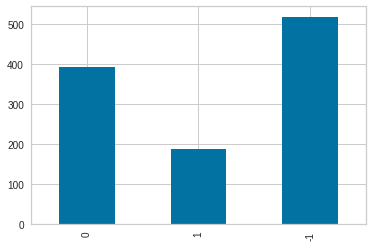

In [9]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced (and generally too less) data, therefore up-sampling will be applied after Train/Test split.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

No need for Dev-Set, as we use cross-validation for model tuning.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rating,
                                                            test_size=0.15, random_state=random_state)

print("X shapes (train/dev/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/dev/test):", y_train.shape, "/", y_test.shape)

X shapes (train/dev/test): (931,) / (165,)
y shapes (train/dev/test): (931,) / (165,)


#### Up-Sampling

In [11]:
X_samples = pd.concat([X_train, y_train], axis=1)
print(X_samples.shape)
X_samples.rating.value_counts(sort=False)

(931, 2)


-1    451
 1    156
 0    324
Name: rating, dtype: int64

Up-sample positive (2x, with text shuffle and random word skipping)

In [12]:
skip_frac = 0.2 # Fraction of words to be skipped from text during up-sampling

def shuffle_and_skip(txt, frac):
    """ Removes fraction of words in text and shuffles word order. """
    words = txt.split()
    sampled_words = random.sample(words, int(len(words) * (1 - frac)))
    random.shuffle(sampled_words)
    return " ".join(sampled_words)

positive_upsamples = X_samples[X_samples.rating == 1].copy()
positive_upsamples.cleaned_txt = positive_upsamples.cleaned_txt.apply(lambda x: shuffle_and_skip(x, skip_frac))

X_upsampled = pd.concat([X_samples, positive_upsamples], axis=0)
print(X_upsampled.shape)
X_upsampled.rating.value_counts(sort=False)

(1087, 2)


-1    451
 1    312
 0    324
Name: rating, dtype: int64

In [13]:
X_train = X_upsampled.cleaned_txt
y_train = X_upsampled.rating

### Vectorizer

In [14]:
count_vect = CountVectorizer(lowercase=False, # already lowercased
                             tokenizer=word_tokenize,
                             ngram_range=(1,2),
                             max_features=10000) # tune max_features for generalization eventually

tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize,
                        ngram_range=(1,2),
                        max_features=10000) # tune max_features for generalization eventually, 25000 3gram

### Models

In [15]:
logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
nb = MultinomialNB()
#nn = MLPClassifier(learning_rate="adaptive", solver="adam", random_state=random_state)

models = [logreg, nb]

Parameters

In [16]:
params = {}
params["LogisticRegression"] = {"penalty": ["l1", "l2"],
                                "C": [0.01, 1., 10., 50., 100., 150., 200.],
                                "class_weight": [None, "balanced"]}
params["MultinomialNB"] = {"alpha": [0., 1.],
                           "fit_prior": [True, False]}
#params["MLPClassifier"] = {"hidden_layer_sizes": [(512,256,64,)]}

### Pipeline

In [17]:
classifiers = {}

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("count_vect", count_vect),
        #("tfidf", tfidf),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring="accuracy", cv=8, refit=True, n_jobs=-1))
    ])

Train

In [18]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is s

Predict

In [19]:
best_acc = 0
best_model_pipe = None

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(acc, name, clf_pipeline.named_steps["clf"].best_params_, clf_pipeline.named_steps["clf"].best_score_)
    
    if acc > best_acc:
        best_model_pipe = clf_pipeline
        best_acc = acc

0.5393939393939394 LogisticRegression_pipe {'C': 10.0, 'class_weight': None, 'penalty': 'l2'} 0.6421343146274149
0.509090909090909 MultinomialNB_pipe {'alpha': 0.0, 'fit_prior': False} 0.6660533578656854


In [20]:
#len(best_model_pipe.named_steps["tfidf"].get_feature_names())

## Evaluation

In [21]:
class_encoding = {1: "positive", 0: "neutral", -1: "negative"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


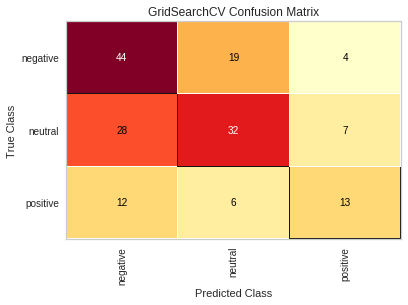

In [22]:
cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

          -1       0.52      0.66      0.58        67
           0       0.56      0.48      0.52        67
           1       0.54      0.42      0.47        31

    accuracy                           0.54       165
   macro avg       0.54      0.52      0.52       165
weighted avg       0.54      0.54      0.54       165



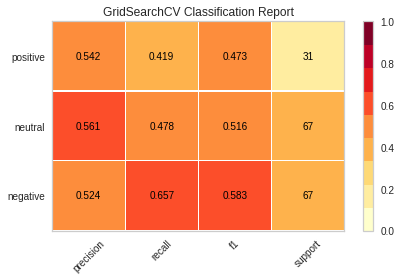

In [23]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from

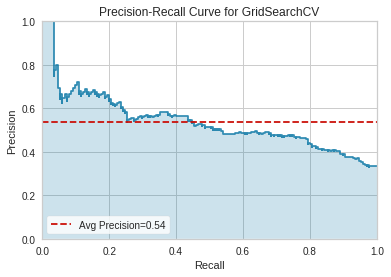

In [24]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


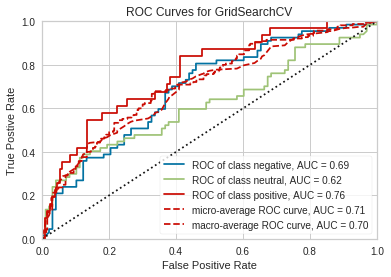

In [25]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

